## Polygon Flood Contours
Created by Brandon Tucker in 2023 <br> 
<br>
In this example, we will create contours as polygons based on the maximum flooding outputs from ADCIRC, <br> then export those polygons as a .shp file. This is the first step in Kalpana's downscaling process. <br>

One of the main assumptions we make with Kalpana is that these areas have a constant flooding level.<br> 

For this example, we will study Hurricane Irene in 2011

In [1]:
import os
import numpy as np
import netCDF4 as netcdf
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from kalpana.export import nc2shp
from kalpana.plotting import plot_nc, plot_kalpana_gdf

First, let's take a look at the maxele.63.nc file, which is the primary input to Kalpana. <br>
This file contains maximum water level data as an output of ADCIRC. <br>
**The following cell creates a visualization of the maxele.63.nc file for Hurricane Florence.**

<GeoAxesSubplot: xlabel='Longitude [deg]', ylabel='Latitude [deg]'>

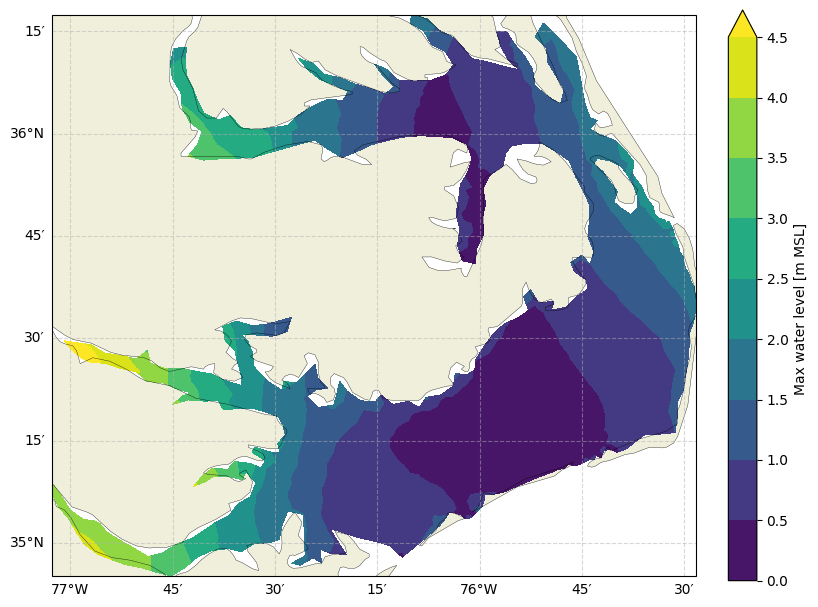

In [4]:
## path to netcdf file
nc_file = r'../../adds/inputs_examples/maxele.63.nc' 
nc = netcdf.Dataset(nc_file)

## flooding levels to plot: min, max, step
levels = np.arange(0, 5, 0.5)

# visualize the netcdf file
plot_nc(nc, 'zeta_max', levels, cbar = True, cb_label = 'Max water level [m MSL]',
        background_map=True, extend='max')

Next, we will use the nc2shp() function to create contours based on these maximum water levels. <br>
**The following cell defines our parameters for the nc2shp() function.**

In [5]:
######## for more detail about the nc2shp inputs please read the function's docstring

## path of the adcirc maxele output file, must be a netcdf file
ncFile = r'../../adds/inputs_examples/maxele.63.nc' 

## name of the maxele variable to downscale. Always 'zeta_max' for downscaling
var = 'zeta_max'

## Contour levels. Min, Max and Step. Max IS included as in np.arange method. Values must be in vUnitOut vertical unit.
## from 0 to 3 meters (included) every 0.5
levels = [0, 5.5, 0.5]

## 'polyline' or 'polygon'
## we are creating polygons in this example
conType = 'polygon'

## complete path of the output file (*.shp or *.gpkg)
pathOut = 'water_level_contours_as_polygons.gpkg'

## coordinate system of the output shapefile
epsgOut = 4326  # output in latitude and longitude, based on downscaling DEM

## input and output vertical units. For the momment only supported 'm' and 'ft'  
vUnitIn = 'm' ## Default 'm'
vUnitOut = 'm' ## Default 'ft'

## coordinate system of the adcirc input.
## Default is 4326 since ADCIRC uses latitude and longitude
epsgIn = 4326  

## complete path of the subdomain polygon kml or shapelfile, or list with the
## upper-left x, upper-left y, lower-right x and lower-right y coordinates. 
## the crs must be the same of the adcirc input file. 
subDomain = None  ## Default None

## True for export the mesh geodataframe and also save it as a shapefile. 
## for this example we are only exporting the contours, not the mesh.
exportMesh = False  ## Default False

## file name of the output mesh shapefile. Default None
meshName = None  ## Default None

## full path of the pickle file with the vertical difference between datums for each mesh node. 
dzFile = None  ## Default None

## threshold for using nearest neighbor interpolation to change datum. Points below this value won't be changed.
zeroDif = -20  ## Default -20

## threshold to define the percentage of the dz given by the spatial interpolation to be applied.
maxDif = -5

## distance threshold for limiting the inverse distance-weighted (IDW) interpolation
distThreshold = 0.5

## number of points return in the kdtree query
k = 7

## timesteps to extract if working with a time-varying ADCIRC output file
timesteps = None

Now, let's call the nc2shp() function with the parameters we defined. <br>

In [6]:
## call nc2shp() and store output as geodataframe
gdf = nc2shp(ncFile, var, levels, conType, pathOut, epsgOut, vUnitOut=vUnitOut, vUnitIn=vUnitIn, epsgIn=epsgIn,
           subDomain=subDomain, exportMesh=exportMesh, meshName=meshName, dzFile=dzFile, zeroDif=zeroDif,
           maxDif=maxDif, distThreshold=distThreshold, k=k, timesteps=timesteps)

2024-06-19 21:30:46.798 | INFO     | kalpana.export:nc2shp:817 - Start exporting adcirc to shape
2024-06-19 21:30:46.820 | INFO     | kalpana.export:filledContours2gpd:311 - Begin computing contours using Dask
2024-06-19 21:30:46.829 | INFO     | kalpana.export:filledContours2gpd:313 - Finnished computing contours using Dask
2024-06-19 21:30:46.834 | INFO     | kalpana.export:nc2shp:847 -     Ready with the contours extraction: 0.001 min
2024-06-19 21:30:46.876 | INFO     | kalpana.export:nc2shp:884 -     Saving file: 0.001 min
2024-06-19 21:30:46.877 | INFO     | kalpana.export:nc2shp:901 - Ready with exporting code after: 0.001 min


In [7]:
## clean repo
os.remove(pathOut)

**The following cell visualizes the output polygon contours of nc2shp().**

<GeoAxesSubplot: >

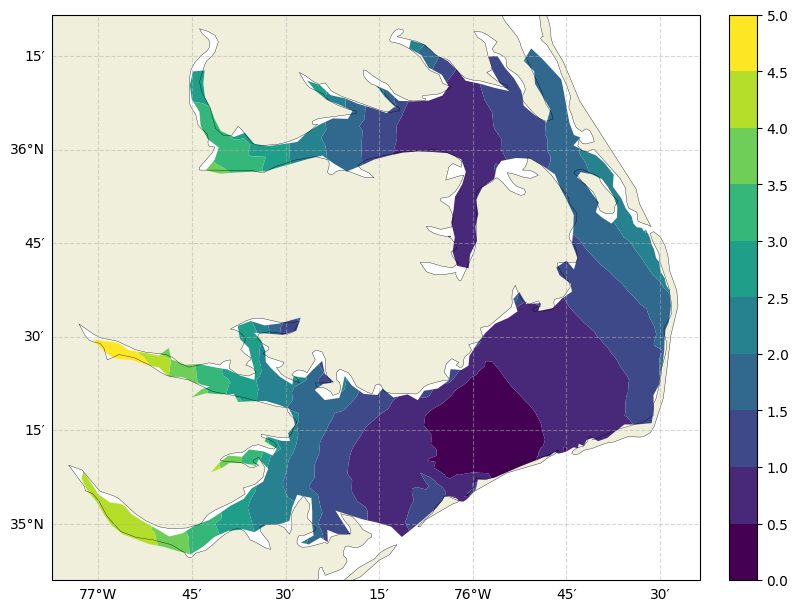

In [8]:
levels = np.arange(0, 5.5, 0.5)
plot_kalpana_gdf(gdf, levels)

Finally, we can look at the original maximum flooding levels and the contours we generated side-by-side.

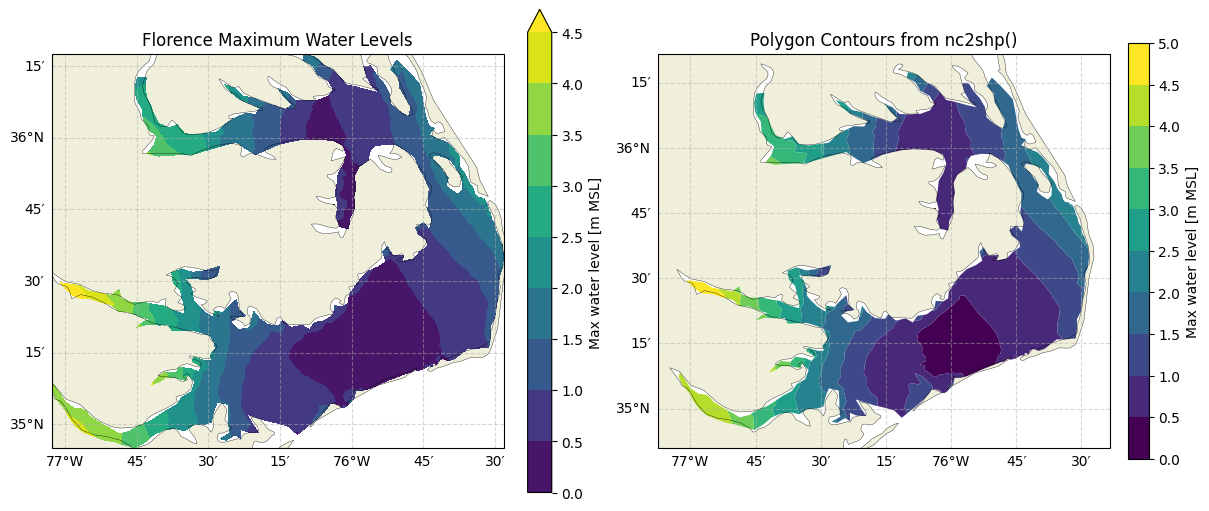

In [10]:
# create two subplots
fig, ax = plt.subplots(figsize = (12, 5), nrows = 1, ncols = 2,  subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)

# visualize the netcdf file for the NC bounds
plot_nc(nc, 'zeta_max', np.arange(0, 5, 0.5), cbar = True, cb_label = 'Max water level [m MSL]',
        background_map=True, ax = ax[0], fig = fig, extend='max')
ax[0].set_xlabel('Longitude [deg]')
ax[0].set_ylabel('Latitude [deg]')
ax[0].set_title('Florence Maximum Water Levels')

# visualize polygons for the NC bounds
plot_kalpana_gdf(gdf, levels, var = 'zMean', ax = ax[1], fig = fig, fsize = (8,6), cbar = True, 
          cbar_label = 'Max water level [m MSL]')
ax[1].set_xlabel('Longitude [deg]')
ax[1].set_ylabel('Latitude [deg]')
ax[1].set_title('Polygon Contours from nc2shp()');

Good luck with Kalpana! See you in future examples! <br>